In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier




In [71]:
# Load the Titanic training dataset from CSV file
df = pd.read_csv(r"../data/train.csv")

# Display the first 5 rows to get a quick look at the data
print(df.head())

# Show concise summary of the dataframe:
# - column names
# - number of non-null entries
# - data types
print(df.info())

# Show basic statistical details for numerical columns
# - count, mean, std, min, max, quartiles
print(df.describe())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

In [72]:
# Check how many missing values are in each column
# This helps identify columns that need cleaning or imputation
print(df.isnull().sum())

# Count how many passengers are male and female
# Useful to see class imbalance in the 'Sex' feature
print(df['Sex'].value_counts())

# Count how many passengers embarked from each port (C, Q, S)
# Helps understand distribution and spot missing values in 'Embarked'
print(df['Embarked'].value_counts())

# Count how many passengers are in each passenger class (1, 2, 3)
# Gives an idea of socio-economic distribution on the ship
print(df['Pclass'].value_counts())

# Show statistical summary for numerical columns: Age, Fare, SibSp, Parch
# Includes mean, std, min, max, and quartiles
print(df[['Age', 'Fare', 'SibSp', 'Parch']].describe())



PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Sex
male      577
female    314
Name: count, dtype: int64
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64
Pclass
3    491
1    216
2    184
Name: count, dtype: int64
              Age        Fare       SibSp       Parch
count  714.000000  891.000000  891.000000  891.000000
mean    29.699118   32.204208    0.523008    0.381594
std     14.526497   49.693429    1.102743    0.806057
min      0.420000    0.000000    0.000000    0.000000
25%     20.125000    7.910400    0.000000    0.000000
50%     28.000000   14.454200    0.000000    0.000000
75%     38.000000   31.000000    1.000000    0.000000
max     80.000000  512.329200    8.000000    6.000000


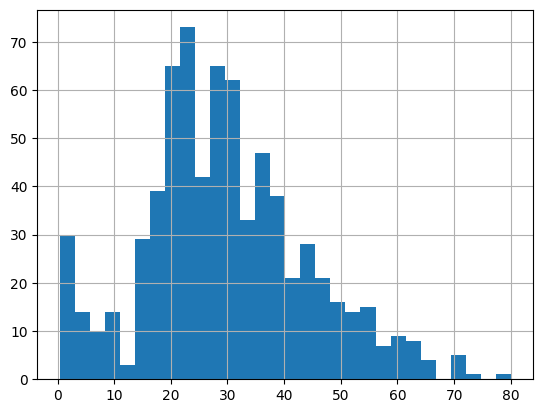

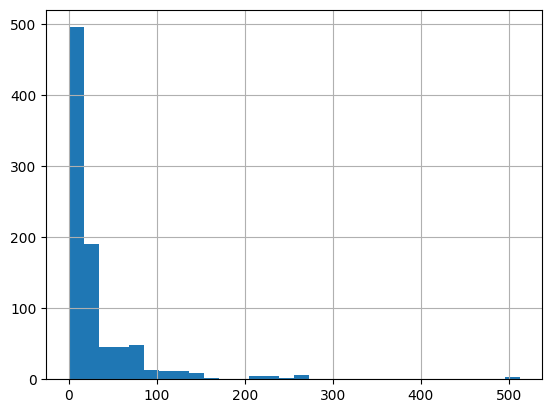

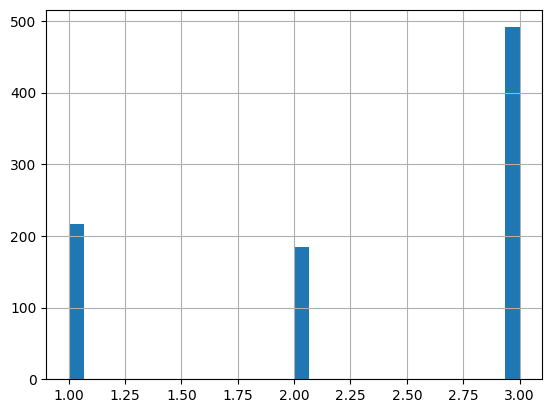

In [73]:
# Plot a histogram of Age to see the distribution of passenger ages
# 'bins=30' splits the age range into 30 intervals for clarity
df['Age'].hist(bins=30)
plt.show()

# Plot a histogram of Fare to visualize ticket price distribution
# Can reveal outliers or skewed distribution
df['Fare'].hist(bins=30)
plt.show()

# Plot a histogram of Pclass to see how many passengers are in each class
# Helps understand the class distribution on the Titanic
df['Pclass'].hist(bins=30)
plt.show()


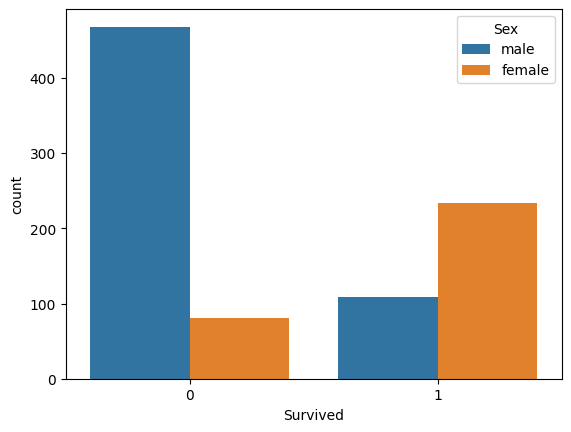

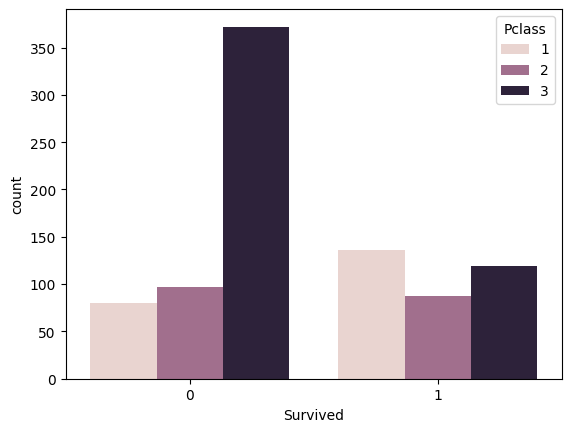

In [34]:
# Survival by Gender
sns.countplot(x='Survived', hue='Sex', data=df)
plt.show()

# Survival by Class
sns.countplot(x='Survived', hue='Pclass', data=df)
plt.show()

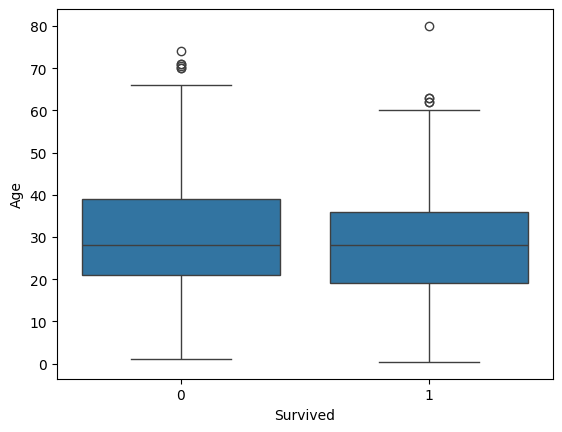

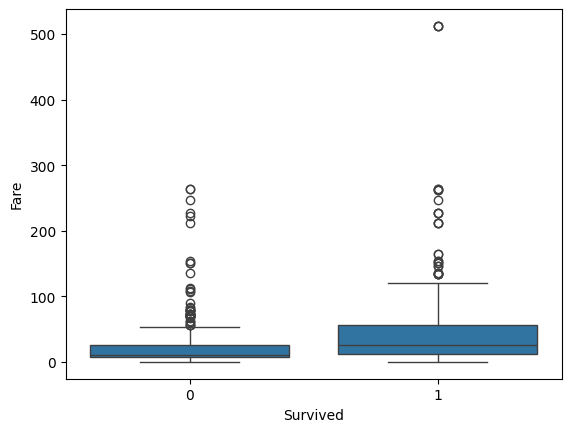

In [74]:
# Boxplot of Age vs Survived
# Helps visualize how age distribution differs between passengers who survived (1) and did not survive (0)
sns.boxplot(x='Survived', y='Age', data=df)
plt.show()

# Boxplot of Fare vs Survived
# Shows the relationship between ticket price and survival
# Can help identify if passengers who paid higher fares had higher chances of survival
sns.boxplot(x='Survived', y='Fare', data=df)
plt.show()


In [75]:

# Drop columns that are not useful for modeling:
# - 'Cabin': too many missing values (~77%)
# - 'Ticket': mostly unique identifiers, not predictive
# - 'Name': contains passenger names, which we will process separately if needed (like extracting titles)
df = df.drop(['Cabin', 'Ticket', 'Name'], axis=1)

# Display the first 5 rows to verify that the columns were dropped
df.head()


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [42]:
# Fill missing values in 'Embarked' with the most common port
# 'mode()[0]' gives the value that appears most frequently
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Extract title (Mr, Mrs, Miss, etc.) from the 'Name' column
# This can be useful as a feature because titles often correlate with age and social status
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Fill missing Age values based on the median age for each title
# For example, missing Ages for 'Mr' will be filled with median age of all 'Mr'
df['Age'] = df.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))

# Convert 'Sex' column to numeric: male=0, female=1
# This is required because machine learning models work with numbers
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

# One-hot encode 'Embarked' column
# Creates separate binary columns for each port (Embarked_C, Embarked_Q, Embarked_S)
df = pd.get_dummies(df, columns=['Embarked'], prefix='Embarked')

# Create a new feature 'FamilySize' by combining SibSp and Parch
# Adding 1 to include the passenger themselves
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1


In [48]:
# Extract title (Mr, Mrs, Miss, etc.) from the 'Name' column
# Titles can indicate social status, gender, and sometimes age, which helps in prediction
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Simplify rare or uncommon titles by grouping them into a single category 'Rare'
# This prevents having too many small categories, which can confuse the model
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'], 'Rare')

# Standardize some variations of titles to common ones
df['Title'] = df['Title'].replace('Mlle', 'Miss')  # Mlle = Mademoiselle
df['Title'] = df['Title'].replace('Ms', 'Miss')    # Ms mapped to Miss
df['Title'] = df['Title'].replace('Mme', 'Mrs')    # Mme = Madame

# Convert titles to numeric values for machine learning models
# Mapping is arbitrary but consistent: Mr=1, Miss=2, Mrs=3, Master=4, Rare=5
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
df['Title'] = df['Title'].map(title_mapping)



In [49]:
# Create a new feature 'IsAlone' to indicate whether the passenger is traveling alone
# Initialize all values as 0 (not alone)
df['IsAlone'] = 0

# Set 'IsAlone' to 1 for passengers whose FamilySize is 1
# FamilySize = 1 means no siblings/spouse or parents/children aboard, i.e., traveling alone
df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1



In [59]:

# Separate features (X) and target variable (y)
# X_train contains all columns except 'Survived' (the features used for prediction)
X_train = df.drop('Survived', axis=1)
# y_train is the target variable we want to predict (0 = did not survive, 1 = survived)
y_train = df['Survived']

# Create a Random Forest classifier
# n_estimators=100 means 100 decision trees will be used in the forest
# random_state=42 ensures reproducibility of results
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest model on the training data
model.fit(X_train, y_train)




RandomForestClassifier(random_state=42)

In [77]:


# Load the Titanic test dataset from CSV file
df_test = pd.read_csv(r"../data/test.csv")

# Extract title (Mr, Mrs, Miss, etc.) from the 'Name' column
# Titles can indicate social status, gender, and sometimes age
df_test['Title'] = df_test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Simplify rare titles by grouping uncommon ones into 'Rare'
# This prevents too many small categories which may confuse the model
df_test['Title'] = df_test['Title'].replace(['Lady', 'Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'], 'Rare')

# Standardize some variations of titles to common ones
df_test['Title'] = df_test['Title'].replace('Mlle', 'Miss')  # Mlle = Mademoiselle
df_test['Title'] = df_test['Title'].replace('Ms', 'Miss')    # Ms mapped to Miss
df_test['Title'] = df_test['Title'].replace('Mme', 'Mrs')    # Mme = Madame

# Encode titles as numbers (same mapping as train set)
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
df_test['Title'] = df_test['Title'].map(title_mapping)

# Fill missing Age values based on median age for each title
# Ensures Age column has no missing values
df_test['Age'] = df_test.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))

# Fill missing Fare values (only one missing in test set)
df_test['Fare'].fillna(df_test['Fare'].median(), inplace=True)

# Fill missing Embarked values if any exist (rare in test set)
df_test['Embarked'].fillna(df_test['Embarked'].mode()[0], inplace=True)

# Convert 'Sex' to numeric: male=0, female=1
df_test['Sex'] = df_test['Sex'].map({'male': 0, 'female': 1})

# One-hot encode 'Embarked' column to create separate binary features
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

# Create new feature 'FamilySize' as sum of SibSp + Parch + 1 (self)
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

# Create 'IsAlone' feature: 1 if passenger is alone, 0 otherwise
df_test['IsAlone'] = 0
df_test.loc[df_test['FamilySize'] == 1, 'IsAlone'] = 1

# Drop columns not needed for modeling
# 'Cabin', 'Ticket', 'Name' are dropped; 'errors="ignore"' avoids errors if columns don't exist
df_test = df_test.drop(['Cabin', 'Ticket', 'Name'], axis=1, errors='ignore')

# Display first 5 rows of the preprocessed test set
df_test.head()


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Title,Embarked_C,Embarked_Q,Embarked_S,FamilySize,IsAlone
0,892,3,0,34.5,0,0,7.8292,1,False,True,False,1,1
1,893,3,1,47.0,1,0,7.0000,3,False,False,True,2,0
2,894,2,0,62.0,0,0,9.6875,1,False,True,False,1,1
3,895,3,0,27.0,0,0,8.6625,1,False,False,True,1,1
4,896,3,1,22.0,1,1,12.2875,3,False,False,True,3,0


In [78]:
# Make predictions on the preprocessed test dataset using the trained Random Forest model
predictions = model.predict(df_test)

# Show the first 10 predictions
print(predictions[:10])


[0 0 0 1 0 0 0 0 1 0]


In [79]:
len(predictions)

418

In [80]:
sum(predictions)

163